<a href="https://colab.research.google.com/github/alfeenafsal11/Exam-Cheating-Detection/blob/main/Examcheatingdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install opencv-python numpy torch torchvision torchaudio
!pip install ultralytics  # YOLO


In [15]:
import zipfile
import os

dataset_path = "/content/shailja.zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully.")


Dataset extracted successfully.


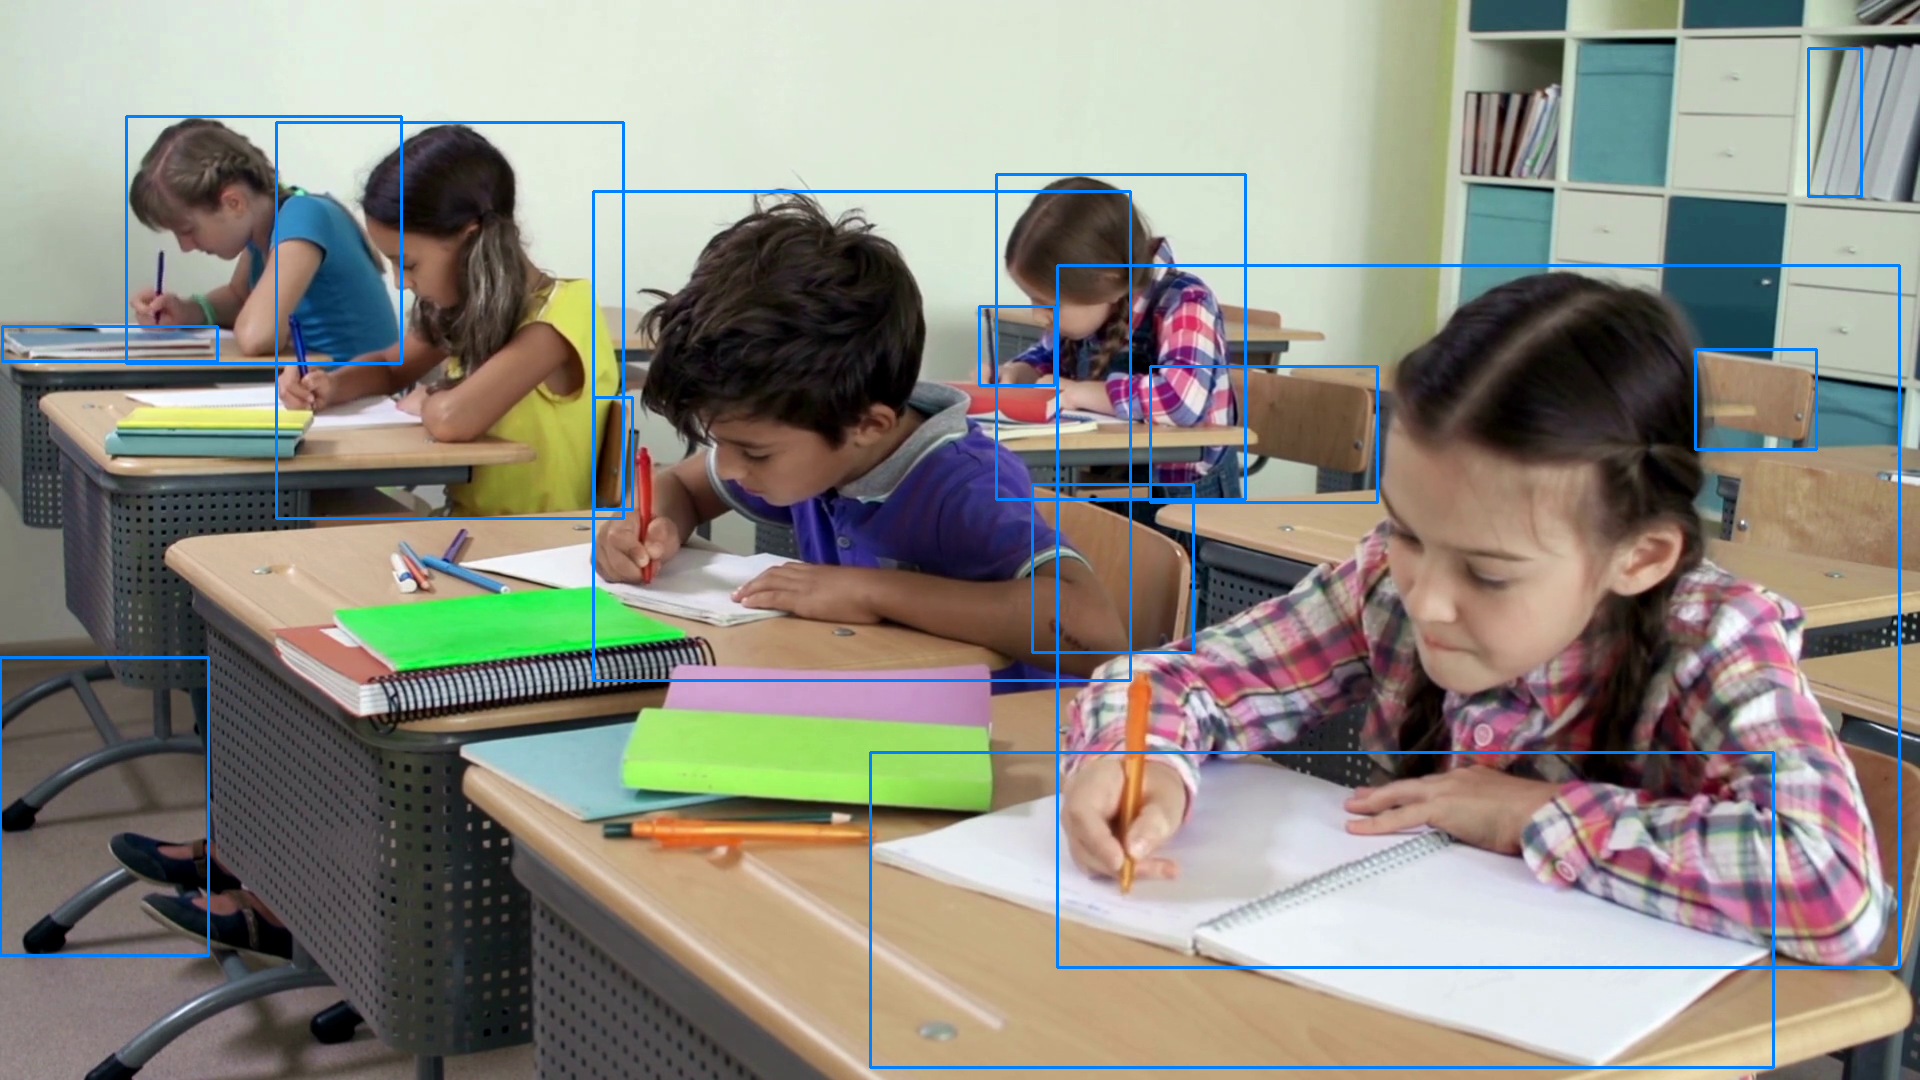

Frames and detections saved successfully!


In [16]:
import cv2
import time
import os
import json
from google.colab.patches import cv2_imshow
from ultralytics import YOLO
from IPython.display import clear_output

# Load YOLO model
model = YOLO("/content/dataset/exam_cheating/yolo11x.pt")

video_path = "/content/testvideo.mp4"
cap = cv2.VideoCapture(video_path)

frame_count = 0
max_frames = 100  # Avoid excessive output in Colab

# Create directories to save data
os.makedirs("/content/saved_frames", exist_ok=True)
os.makedirs("/content/saved_detections", exist_ok=True)

detections = []  # Store all detections

while cap.isOpened() and frame_count < max_frames:
    for _ in range(3):
        cap.grab()
    ret, frame = cap.retrieve()
    if not ret:
        print(f"Error reading frame {frame_count}. Exiting...")
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = model(frame_rgb)

    frame_data = {"frame": frame_count, "objects": []}  # Store detection info

    for result in results:
        for box in result.boxes.xyxy.cpu().numpy():
            x1, y1, x2, y2 = map(int, box[:4])
            class_id = int(result.boxes.cls.cpu().numpy()[0])  # Get class ID
            frame_data["objects"].append({"class_id": class_id, "bbox": [x1, y1, x2, y2]})

            # Draw bounding box on the frame
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 127, 0), 2)

    detections.append(frame_data)  # Save detection info

    # Save the frame
    frame_path = f"/content/saved_frames/frame_{frame_count}.jpg"
    cv2.imwrite(frame_path, frame)

    clear_output(wait=True)  # Clears previous frame output
    cv2_imshow(frame)
    time.sleep(0.05)  # Simulate ~20 FPS
    frame_count += 1

cap.release()
cv2.destroyAllWindows()

# Save detections to a JSON file
with open("/content/saved_detections/detections.json", "w") as f:
    json.dump(detections, f, indent=4)

print("Frames and detections saved successfully!")

In [17]:
import json
import numpy as np

# Load detections from JSON file
with open("/content/saved_detections/detections.json", "r") as f:
    detections = json.load(f)

features = []
labels = []

CHEATING_CLASS_ID = 2  # Ensure this matches the correct index in your YAML
max_objects = 10  # Define max objects per frame

for frame_data in detections:
    frame_features = []
    label = 0  # Default: No cheating detected

    for obj in frame_data["objects"]:
        class_id = obj["class_id"]
        bbox = obj["bbox"]

        frame_features.append(bbox)  # Store bounding box

        # Assign label based on detected class
        if class_id == CHEATING_CLASS_ID:
            label = 1

    # Ensure features have a fixed length
    frame_features = frame_features[:max_objects] + [[0, 0, 0, 0]] * (max_objects - len(frame_features))

    features.append(frame_features)
    labels.append(label)

print(f"Total frames processed: {len(features)}")
print(f"Total labels: {len(labels)}")

Total frames processed: 100
Total labels: 100


In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Pad sequences to have the same length
max_length = 50  # Adjust based on dataset
features_padded = pad_sequences(features, maxlen=max_length, padding='post', dtype='float32')
print(features_padded.shape)
# Convert labels to categorical
import numpy as np
from tensorflow.keras.utils import to_categorical

# Fix: Convert back to class indices before applying to_categorical
labels = np.array(labels)
if labels.ndim == 2 and labels.shape[1] == 2:
    labels = np.argmax(labels, axis=1)  # Convert one-hot to class indices

labels = to_categorical(labels, num_classes=2)
print("Final labels shape:", labels.shape)  # Should be (100, 2)


(100, 50, 4)
Final labels shape: (100, 2)


In [35]:
#Attempt 1:# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten

# model = Sequential([
#     LSTM(64, return_sequences=True, input_shape=(max_length, 4)),  # LSTM expects sequential input
#     LSTM(32, return_sequences=False),
#     Flatten(),
#     Dense(32, activation='relu'),
#     Dropout(0.5),
#     Dense(2, activation='softmax')  # Two classes: cheating, non-cheating
# ])
#Attempt 2:
# from tensorflow.keras.layers import LSTM

# # This will work across CPU and GPU
# LSTM(64, activation='tanh', recurrent_activation='sigmoid')


# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking

model = Sequential()
model.add(Masking(mask_value=0., input_shape=(max_length, 4)))  # (timesteps, features), here 4 = bbox coords
model.add(LSTM(64, activation='tanh', recurrent_activation='sigmoid', implementation=2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)                  │ (None, 50, 4)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,794 (69.51 KB)

 Trainable params: 17,794 (69.51 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:

print("Features shape:", features_padded.shape)
print("Labels shape:", labels.shape)
print(labels[0])

Features shape: (100, 50, 4)
Labels shape: (100, 2)
[          1           0]


In [37]:
import tensorflow as tf
print("GPUs available:", tf.config.list_physical_devices('GPU'))


GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [39]:
import os
os.environ['TF_ENABLE_CUDNN_RNN'] = '0'  # Disable CuDNN RNN kernels

import numpy as np
import tensorflow as tf

# Ensure data types are correct:
features_padded = features_padded.astype('float32')
labels = labels.astype('float32')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking

model = Sequential()
model.add(Masking(mask_value=0., input_shape=(50, 4)))
model.add(LSTM(64, activation='tanh', recurrent_activation='sigmoid', implementation=2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(features_padded, labels, epochs=10, batch_size=8, validation_split=0.2)


Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node sequential_4_1/lstm_4_1/CudnnRNNV3 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-39-8d58e2a09215>", line 20, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 57, in train_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py", line 213, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 182, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 637, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/lstm.py", line 584, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py", line 402, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/lstm.py", line 551, in inner_loop

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/rnn.py", line 841, in lstm

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/rnn.py", line 933, in _cudnn_lstm

Dnn is not supported
	 [[{{node sequential_4_1/lstm_4_1/CudnnRNNV3}}]] [Op:__inference_multi_step_on_iterator_6785]

In [38]:
model.fit(features_padded, labels, epochs=10, batch_size=8, validation_split=0.2)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node sequential_3_1/lstm_3_1/CudnnRNNV3 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-38-5ee8d0ab8141>", line 1, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 57, in train_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/sequential.py", line 213, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 182, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 637, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 908, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/lstm.py", line 584, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py", line 402, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/lstm.py", line 551, in inner_loop

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/rnn.py", line 841, in lstm

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/rnn.py", line 933, in _cudnn_lstm

Dnn is not supported
	 [[{{node sequential_3_1/lstm_3_1/CudnnRNNV3}}]] [Op:__inference_multi_step_on_iterator_5128]